In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
import pickle
import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib, vc_protocols
import mod_trace

from ord2017 import ORD2017

In [2]:
'''
O'Hara CiPA v1.0 2017
'''
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}
current_li = ['ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs', 'ik1.IK1']

protocol = vc_protocols.hERG_CiPA()
# protocol = pickle.load(open("./trial_steps_ramps_Kernik_200_50_4_-120_60_paper/shortened_trial_steps_ramps_Kernik_200_50_4_-120_60_500_artefact_True_short.pkl", 'rb'))
# protocol = pickle.load(open("./trial_steps_ramps_ORD2011_288_51_4_-121_61/shortened_trial_steps_ramps_ORD2011_288_51_4_-121_61_500_artefact_False_short.pkl", 'rb'))

end_time = protocol.get_voltage_change_endpoints()[-1]
t_span = (0, end_time)
t_eval = np.linspace(0, end_time, 10000)
print(end_time)

3900


In [3]:
start_time = time.time()

import simulator_myokit
'''
Simulation with Myokit
'''    
model_myokit, p, s = myokit.load("../../../mmt-model-files/newordherg_qNet_vc_fixedconc-v1.mmt")    
sim_myokit = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-08, rel_tol=1e-8, vhold=-80)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "ohara2017"  

params = {         
    'cell.mode': cell_types['Endocardial'],    
    'setting.simType': 1,   # 0: AP   |  1: VC  
}
sim_myokit.set_simulation_params(params)
sim_myokit.pre_simulate(5000, sim_type=1)
d_myokit = sim_myokit.simulate(end_time, log_times=None, extra_log=['membrane.i_ion', 'ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa'])

sol_myokit = {}
times_myokit = d_myokit['engine.time']
sol_myokit["Voltage"] = [protocol.get_voltage_at_time(t) for t in times_myokit]
sol_myokit["I_Na"] = d_myokit['ina.INa']
sol_myokit["I_Kr"] = d_myokit['ikr.IKr']
sol_myokit["I_Ks"] = d_myokit['iks.IKs']
sol_myokit["I_To"] = d_myokit['ito.Ito']
sol_myokit["I_CaL"] =d_myokit['ical.ICaL']
sol_myokit["I_K1"] = d_myokit['ik1.IK1']
sol_myokit["I_NaL"] = d_myokit['inal.INaL']
   
print("--- %s seconds ---"%(time.time()-start_time))

--- 4.339416980743408 seconds ---


In [11]:
start_time = time.time()

'''
Simulation with Myokit
'''    
model_myokit, p, s = myokit.load("../../../mmt-model-files/ohara-cipa-v1-2017_fixedconc-v1.mmt")    
sim_myokit2 = simulator_myokit.Simulator(model_myokit, protocol, max_step=1.0, abs_tol=1e-08, rel_tol=1e-8, vhold=-80)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit2.name = "ohara2017"  

params = {         
    'cell.mode': cell_types['Endocardial'],    
    'setting.simType': 1,   # 0: AP   |  1: VC  
}
sim_myokit2.set_simulation_params(params)
sim_myokit2.pre_simulate(5000, sim_type=1)
d_myokit2 = sim_myokit2.simulate(end_time, log_times=None, extra_log=['membrane.i_ion', 'ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa'])

sol2 = {}
times2 = d_myokit2['engine.time']
sol2["Voltage"] = [protocol.get_voltage_at_time(t) for t in times2]
sol2["I_Na"] = d_myokit2['ina.INa']
sol2["I_Kr"] = d_myokit2['ikr.IKr']
sol2["I_Ks"] = d_myokit2['iks.IKs']
sol2["I_To"] = d_myokit2['ito.Ito']
sol2["I_CaL"] =d_myokit2['ical.ICaL']
sol2["I_K1"] = d_myokit2['ik1.IK1']
sol2["I_NaL"] = d_myokit2['inal.INaL']
   
print("--- %s seconds ---"%(time.time()-start_time))

--- 4.387958526611328 seconds ---


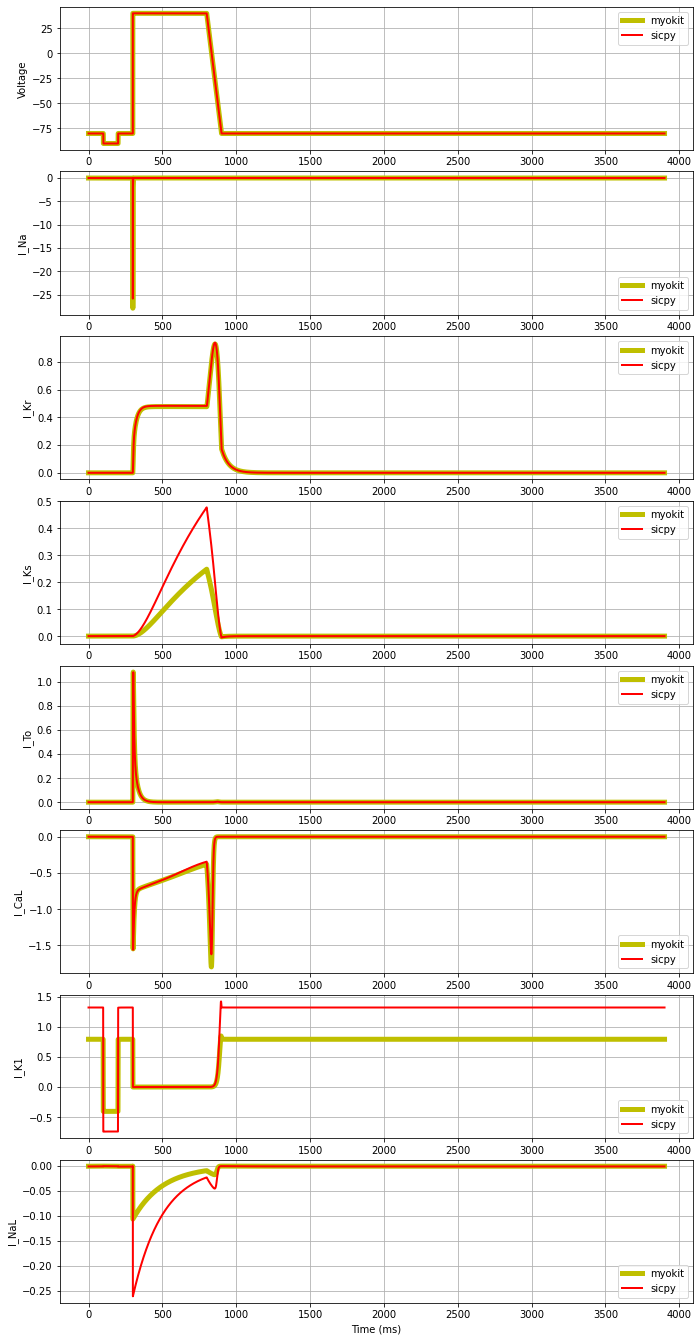

In [14]:
'''
Plot
'''
fig, ax = plt.subplots(8,1, figsize=(10,20))    
# fig.suptitle(sim.name, fontsize=14)
for i, (name, values) in enumerate(sol_myokit.items()):    
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax[i].set_xlabel('Time (ms)')       
    ax[i].set_ylabel(f'{name}')      
    ax[i].plot( times_myokit, values, label='myokit', color='y', linewidth=5)     
    ax[i].plot( times2, sol2[name], label='sicpy', color='r', linewidth=2)   
    ax[i].legend()
    ax[i].grid()

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig(os.path.join('Results', "ORd2011_VC"), dpi=100)

In [ ]:
print("Complete")